## Final Project Submission

Please fill out:
* Student name: Sue Lim
* Student pace: self paced
* Scheduled project review date/time: May 15, 2023, 11:00 AM - 11:45 AM
* Instructor name: Mark Barbour
* Blog post URL: https://medium.com/@limsue9123/assumptions-and-diagnostics-for-linear-regression-bbb2ba25efaf


# I. Data Cleaning & Exploration

In this section, King's county housing data is cleaned by 1) dropping NULL values; 2) transforming the response and the predictor variables as appropriately; and 3) extracting state, county, and zipcode information from the address variable. Additionally, the relationship between the response variable and potentially predictor variables is explored using scatter plots and the correlation matrix.

In [1]:
# Import packages and the house sales data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv("data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


In [2]:
# Drop records containing NULL values

print("Before dropping NULL values: " + str(len(df)) + " records")
df.dropna(axis = 0, inplace = True)
print("After dropping NULL values: " + str(len(df)) + " records")

Before dropping NULL values: 30155 records
After dropping NULL values: 30111 records


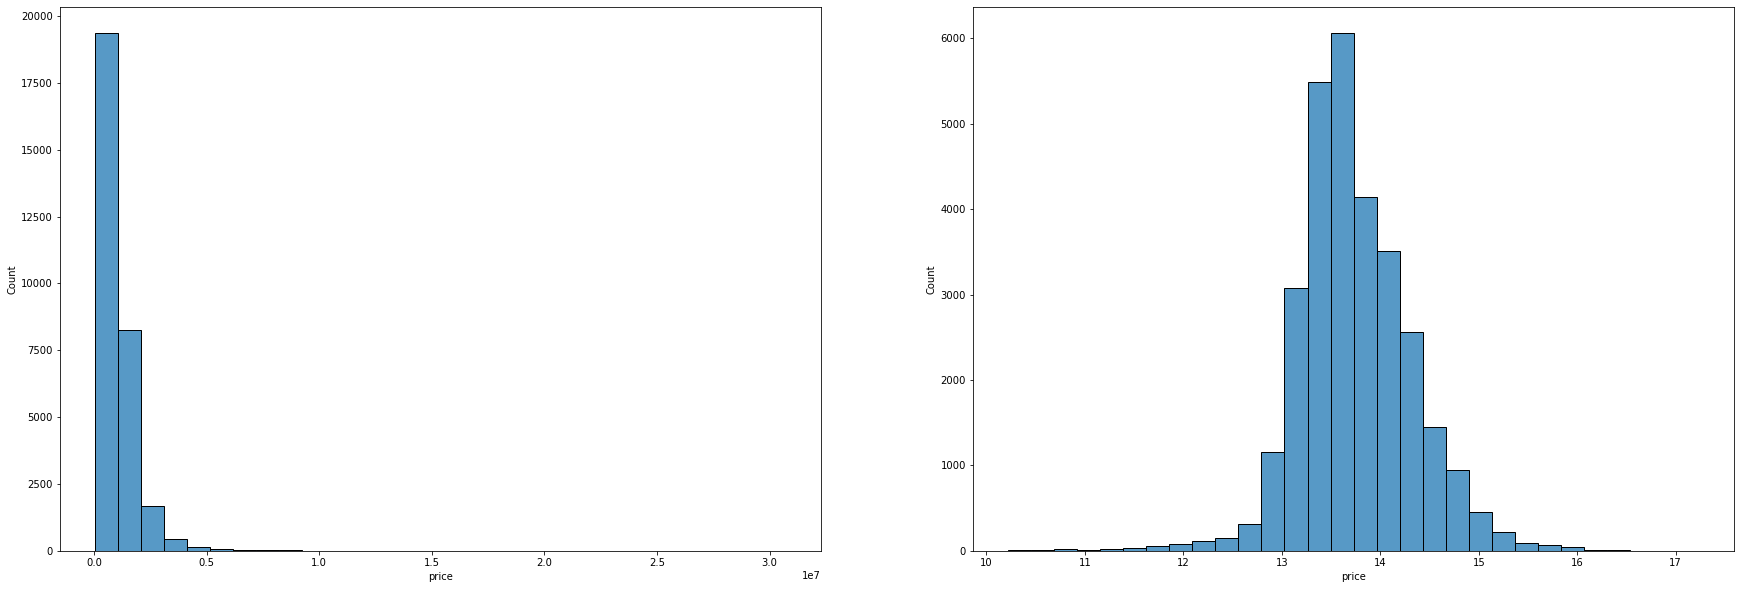

In [3]:
# Plot the distribution of the price variable and the log-transformed price variable
# Use the transformed variable in the regression as it roughly follows the log normal distribution

fig, axes = plt.subplots(ncols = 2, figsize = (30, 10))

sns.histplot(df["price"], bins = 30, ax = axes[0])
sns.histplot(np.log(df["price"]), bins = 30, ax = axes[1]);

In [4]:
# Scrape Zipcode, County, and State from the address variable

df["log_price"] = np.log(df["price"])
df["zipcode"] = df["address"].apply(lambda x: x[-20:-15])
df["county"] = df["address"].str.rsplit(',', 3).apply(lambda x: x[-3][1:])
df["state"] = df["address"].str.rsplit(',', 3).apply(lambda x: x[-2][:-5])

In [5]:
# Clean Zipcode and County further so that the values for which there are less than 30 observations are grouped as Others

df0 = df.copy()

index = df0["zipcode"].value_counts().reset_index()
zipcodes = index[index["zipcode"]>30]
df0["zipcode_clean"] = df0["zipcode"].apply(lambda x: x if x in zipcodes["index"].unique() else "Others")

index = df0["county"].value_counts().reset_index()
counties = index[index["county"]>30]
df0["county_clean"] = df0["county"].apply(lambda x: x if x in counties["index"].unique() else "Others")

In [6]:
# Scrape Transaction Year from the transaction date variable, turn the condition, view, and grade variables into scales
# Take the later of year built and year renovated variables to create a proxy for how modern a home is

df0["yr_transacted"] = df0["date"].apply(lambda x: int(x[-4:])) - 2020
df0["condition"] = df0["condition"].apply(lambda x: 
                                       1 if x == "Poor" else 
                                       (2 if x == "Fair" else 
                                        (3 if x == "Average" else 
                                         (4 if x == "Good" else 5)))) 
df0["view"] = df0["view"].apply(lambda x: 
                                       1 if x == "NONE" else 
                                       (2 if x == "FAIR" else 
                                        (3 if x == "AVERAGE" else 
                                         (4 if x == "GOOD" else 5))))

df0["grade"] = df0["grade"].apply(lambda x: int(x[:2]))

df0["yr_built_renovated"] = df0[["yr_built", "yr_renovated"]].max(axis = 1)

In [7]:
# Filter out outlier records states of which are outside Washington as they are likely to be erroneous records, and
# drop sale prices less than $100K as the data points do not appear to be credible

df1 = df0[(df0["state"] == " Washington ") & (df0["price"] > 100000)]

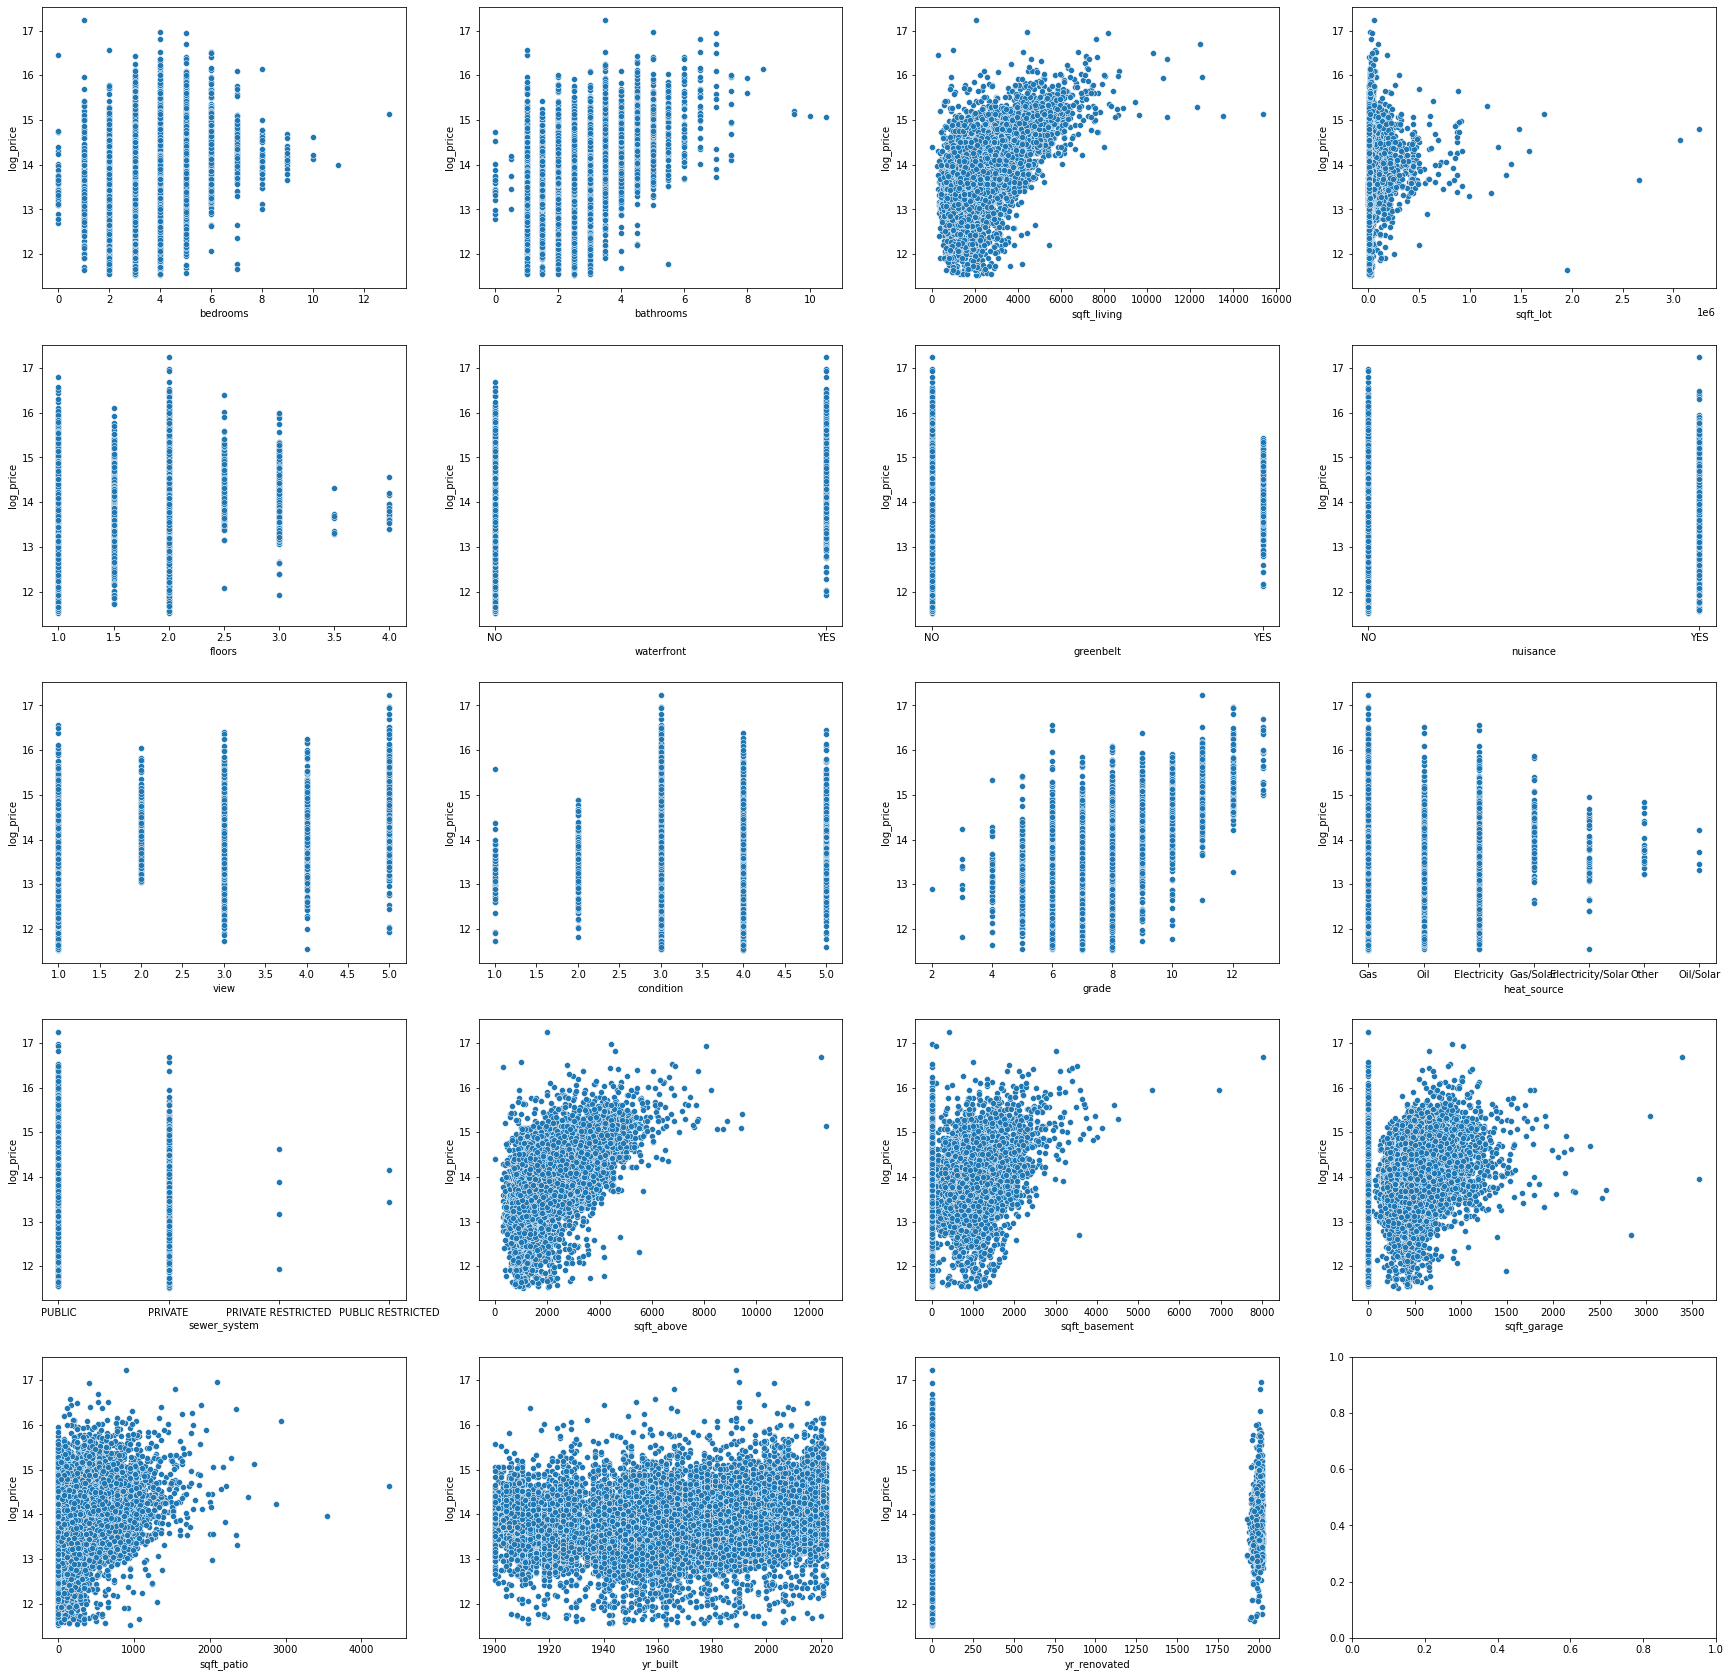

In [8]:
# Plot relationships between the log-transformed price variable and other variables
# (This is not after controlling for all other potential predictor variables but good for preliminary investigation)

fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize = (30, 30))

counter = 0
for i in range(25):
    if (df1.columns[i] in ["id", "date", "price", "address", "lat", "long"]) == False:
        sns.scatterplot(x = df1.iloc[:, i], y = df1["log_price"], ax = axes[np.floor(counter / 4).astype(int), counter % 4])
        counter += 1

In [9]:
# Create a correlation matrix to see if there is any pair of variables with correlation > 0.8

df1.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,log_price,yr_transacted,yr_built_renovated
id,1.000000,-0.030424,-0.004808,-0.012115,-0.027987,-0.120881,0.034147,-0.007873,-0.009407,0.002409,-0.022399,-0.016026,-0.006806,-0.043115,0.022597,-0.029230,-0.000319,0.007848,-0.023787,-0.009248,0.013518
price,-0.030424,1.000000,0.291353,0.488373,0.617706,0.087581,0.198592,0.322747,-0.013574,0.578848,0.547009,0.247359,0.267782,0.317700,0.104761,0.086662,0.296413,0.074326,0.843490,0.069777,0.138252
bedrooms,-0.004808,0.291353,1.000000,0.593349,0.631120,-0.000229,0.193958,0.050993,0.019590,0.387866,0.538020,0.235291,0.305280,0.191725,0.181355,0.010148,-0.016492,0.119901,0.355534,-0.029075,0.190761
bathrooms,-0.012115,0.488373,0.593349,1.000000,0.779924,0.038499,0.426664,0.159957,-0.066694,0.652831,0.680842,0.261173,0.460910,0.333535,0.455345,0.041816,0.046791,0.164083,0.533223,-0.043323,0.483252
sqft_living,-0.027987,0.617706,0.631120,0.779924,1.000000,0.118117,0.354428,0.242025,-0.069448,0.738997,0.881710,0.336382,0.503494,0.405866,0.327853,0.035129,0.048604,0.213423,0.643098,-0.031132,0.347470
sqft_lot,-0.120881,0.087581,-0.000229,0.038499,0.118117,1.000000,-0.020665,0.096087,-0.005177,0.060585,0.127901,0.002359,0.084640,0.157525,0.012711,0.006909,-0.073643,0.167962,0.089471,-0.005158,0.013433
floors,0.034147,0.198592,0.193958,0.426664,0.354428,-0.020665,1.000000,0.006010,-0.267169,0.471060,0.504164,-0.243569,0.177865,0.123431,0.521425,-0.015861,0.046212,0.090026,0.260093,-0.017703,0.532086
view,-0.007873,0.322747,0.050993,0.159957,0.242025,0.096087,0.006010,1.000000,0.027425,0.207909,0.130427,0.265864,0.025111,0.248519,-0.077826,0.108444,0.008329,-0.042766,0.287413,-0.015674,-0.040615
condition,-0.009407,-0.013574,0.019590,-0.066694,-0.069448,-0.005177,-0.267169,0.027425,1.000000,-0.152048,-0.153393,0.090419,-0.084836,0.044399,-0.304442,-0.085531,-0.054733,-0.029405,0.003321,-0.021973,-0.350018
grade,0.002409,0.578848,0.387866,0.652831,0.738997,0.060585,0.471060,0.207909,-0.152048,1.000000,0.720389,0.141855,0.515783,0.352164,0.481345,-0.008976,0.129362,0.167670,0.637850,-0.026396,0.487431


In [10]:
# Log-transform the price variable and create dummy variables and an initial set of predictor variables

y = df1["log_price"]

vars_numeric = df1[["sqft_living", "sqft_lot", "yr_transacted", "condition", "view", "grade"]]

vars_character = pd.get_dummies(df1[["waterfront", "greenbelt", "nuisance"]])
vars_character = vars_character[vars_character.columns[vars_character.columns.str.endswith("YES")]]

vars_zipcode = pd.get_dummies(df1[["zipcode_clean"]], drop_first = True)
vars_county = pd.get_dummies(df1[["county_clean"]], drop_first = True)

X = pd.concat([vars_numeric, vars_character, vars_zipcode, vars_county], axis = 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# II. Regression Result & Model Selection

I run three different potential models to see which one performs the best. The first model uses zipcodes as dummy variables as well as other predictor variables, the second model uses counties instead. The third model does not use either zipcodes or counties. Among them, I pick the first model as the R-squared is highest and AIC & BIC are the lowest.

In [12]:
# Initial regression model and result

model = sm.OLS(y_train, sm.add_constant(X_train.iloc[:, ~X_train.columns.str.startswith("county")]))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     686.8
Date:                Sun, 14 May 2023   Prob (F-statistic):               0.00
Time:                        19:59:01   Log-Likelihood:                -3619.1
No. Observations:               21837   AIC:                             7404.
Df Residuals:                   21754   BIC:                             8068.
Df Model:                          82                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.6636 

In [13]:
# R-squared on validation data

r2_validation = round(r2_score(y_test, results.predict(sm.add_constant(X_test.iloc[:, ~X_test.columns.str.startswith("county")]))) * 100, 1)
print(f"R-squared on validation data is {r2_validation}%")

R-squared on validation data is 76.6%


In [14]:
# Interpret the coefficients

print(f"Compared to the price of ${np.round(np.exp(results.params[0]))} with values of 0 for all predictor variables:")
for i in range(1, len(results.params)):
    if i <= 6:
        print(f"for each increase of 1 unit in {results.params.reset_index().iloc[i, 0]}, the housing price increases by {np.round((np.exp(results.params[i]) - 1) * 100, 2)}%")
    else:
        print(f"if {results.params.reset_index().iloc[i, 0]} is Yes, the housing price increases by {np.round((np.exp(results.params[i]) - 1) * 100, 2)}%")

Compared to the price of $116259.0 with values of 0 for all predictor variables:
for each increase of 1 unit in sqft_living, the housing price increases by 0.02%
for each increase of 1 unit in sqft_lot, the housing price increases by 0.0%
for each increase of 1 unit in yr_transacted, the housing price increases by 15.07%
for each increase of 1 unit in condition, the housing price increases by 6.38%
for each increase of 1 unit in view, the housing price increases by 5.6%
for each increase of 1 unit in grade, the housing price increases by 10.3%
if waterfront_YES is Yes, the housing price increases by 38.37%
if greenbelt_YES is Yes, the housing price increases by 4.81%
if nuisance_YES is Yes, the housing price increases by -3.62%
if zipcode_clean_98002 is Yes, the housing price increases by -9.68%
if zipcode_clean_98003 is Yes, the housing price increases by -3.42%
if zipcode_clean_98004 is Yes, the housing price increases by 223.17%
if zipcode_clean_98005 is Yes, the housing price incre

In [15]:
# Second regression model and result using County instead of Zipcode

model_2 = sm.OLS(y_train,  sm.add_constant(X_train.iloc[:, ~X_train.columns.str.startswith("zipcode")]))
results_2 = model_2.fit(cov_type = "HC3")
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     1026.
Date:                Sun, 14 May 2023   Prob (F-statistic):               0.00
Time:                        19:59:04   Log-Likelihood:                -5132.4
No. Observations:               21837   AIC:                         1.036e+04
Df Residuals:                   21790   BIC:                         1.073e+04
Df Model:                          46                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [16]:
# R-squared on validation data

r2_validation_2 = round(r2_score(y_test, results_2.predict(sm.add_constant(X_test.iloc[:, ~X_test.columns.str.startswith("zipcode")]))) * 100, 1)
print(f"R-squared on validation data is {r2_validation_2}%")

R-squared on validation data is 72.2%


In [17]:
# Third regression model and result using neither Zipcode nor County

model_3 =  sm.OLS(y_train, sm.add_constant(X_train.iloc[:, ~((X_train.columns.str.startswith("zipcode")) | (X_train.columns.str.startswith("county")))]))
results_3 = model_3.fit(cov_type = "HC3")
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     1941.
Date:                Sun, 14 May 2023   Prob (F-statistic):               0.00
Time:                        19:59:05   Log-Likelihood:                -10855.
No. Observations:               21837   AIC:                         2.173e+04
Df Residuals:                   21827   BIC:                         2.181e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.3825      0.032    354.

In [18]:
# R-squared on validation data

r2_validation_3 = round(r2_score(y_test, results_3.predict(sm.add_constant(X_test.iloc[:, ~((X_test.columns.str.startswith("zipcode")) | (X_test.columns.str.startswith("county")))]))) * 100, 1)
print(f"R-squared on validation data is {r2_validation_3}%")

R-squared on validation data is 51.3%


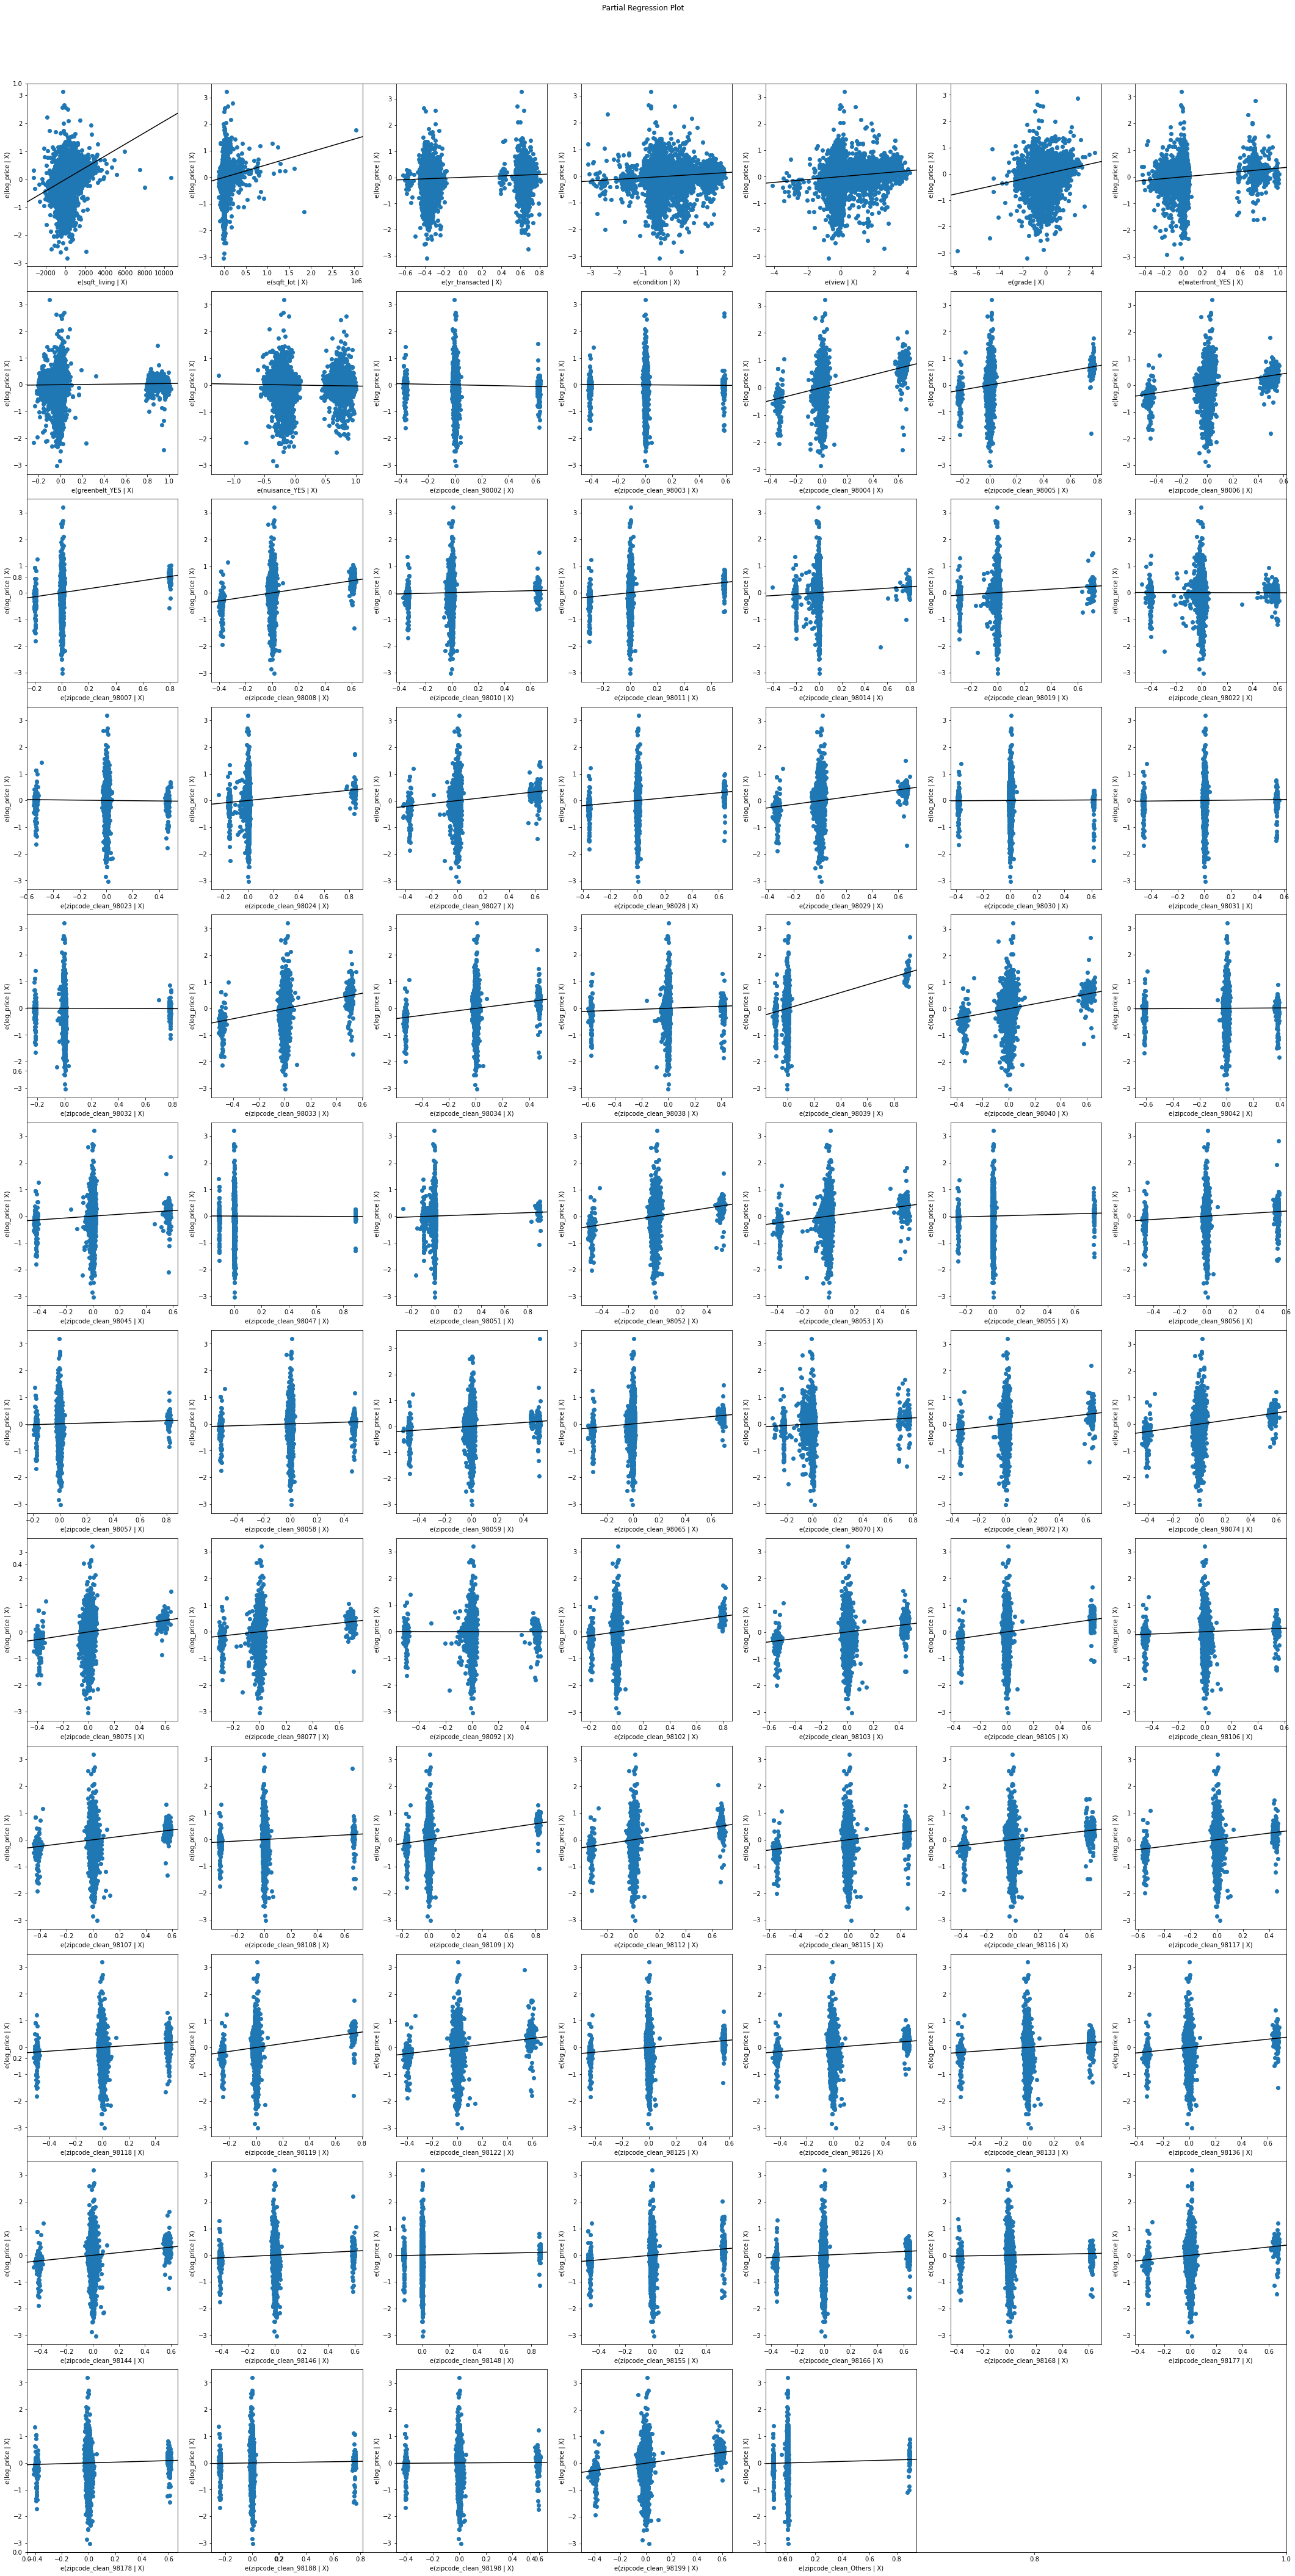

In [19]:
# Plot partial regression plot to diagnose the effect of of each predictor variable after controlling for other variables

fig, ax = plt.subplots(figsize = (30, 60))
sm.graphics.plot_partregress_grid(results, exog_idx = list(X_train.iloc[:, ~X_train.columns.str.startswith("county")].columns), grid = (12, 7), fig = fig)
plt.show()

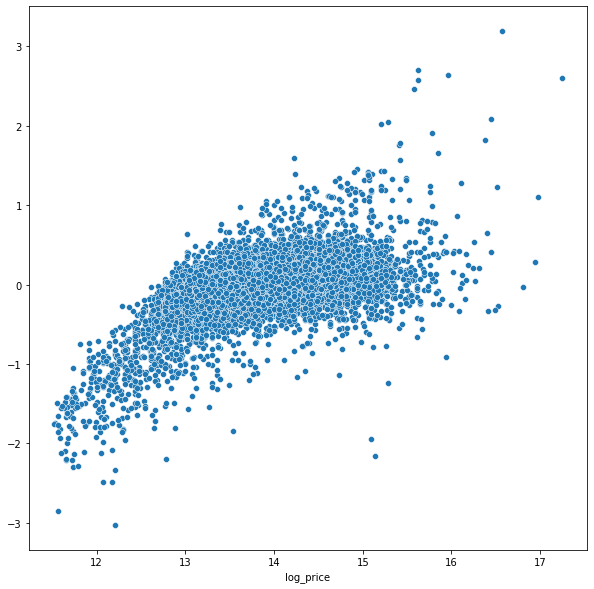

In [20]:
# Plot error terms for diagnostics

fig, ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(x = y_train, y = results.resid, ax = ax);